In [19]:
# Standard library imports
import re
import string
import time

# Third-party library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import inflect

# Scikit-learn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [20]:
df_true = pd.read_csv(r"F:\UNI\8\project\dataset\True.csv")
df_false = pd.read_csv(r"F:\UNI\8\project\dataset\Fake.csv")

In [21]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [22]:
df_false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


## Labeling the dataset: Assign 1 for true news and 0 for false news


In [23]:
df_true["status"] = 1
df_false["status"] = 0

## Combining the dataframes into a single dataframe

In [24]:
df = pd.concat([df_true, df_false])

## Displaying basic information about the dataframe


In [25]:
df.dtypes

title      object
text       object
subject    object
date       object
status      int64
dtype: object

In [26]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
status     0
dtype: int64

In [27]:
df.duplicated().sum()

209

In [28]:
# Removing duplicates
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)

## Organizing subjects

In [29]:
df["subject"].unique()

array(['politicsNews', 'worldnews', 'News', 'politics', 'Government News',
       'left-news', 'US_News', 'Middle-east'], dtype=object)

In [30]:
df["subject"].replace("politicsNews", "politics", inplace=True)

## Generating and displaying various plots for data visualization

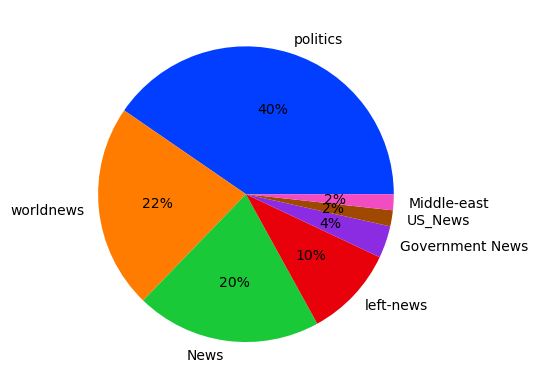

In [13]:
# Plot a pie chart based on the number of news subjects
pie_df = df["subject"].value_counts().reset_index().rename(columns={"index":"subject", "subject":"count"})

palette_color = sns.color_palette('bright') 

plt.pie(x=pie_df["count"], labels=pie_df["subject"], colors=palette_color, autopct='%.0f%%') 
plt.show()

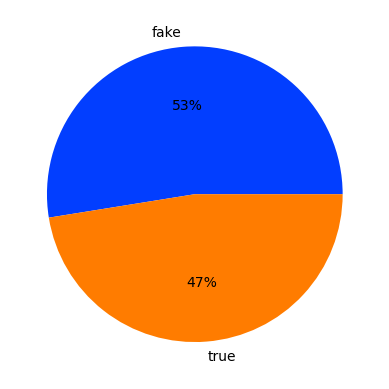

In [14]:
# Plot a pie chart based on news reality
pie_df = df["status"].value_counts().reset_index().rename(columns={"index":"status", "status":"count"})

palette_color = sns.color_palette('bright') 

plt.pie(x=pie_df["count"], labels=["fake", "true"], colors=palette_color, autopct='%.0f%%') 
plt.show()

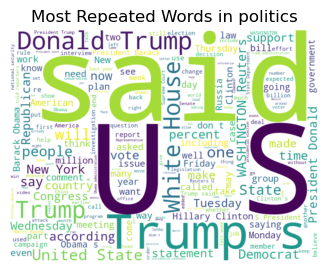

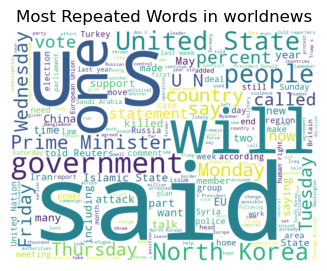

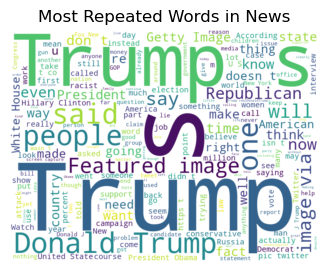

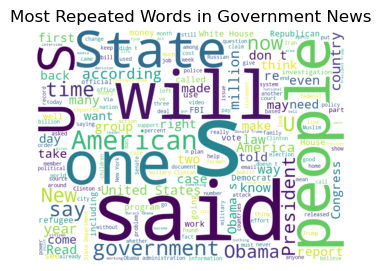

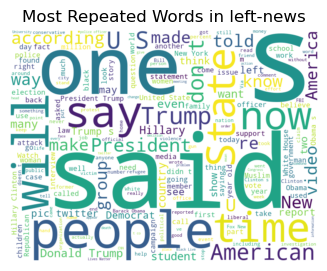

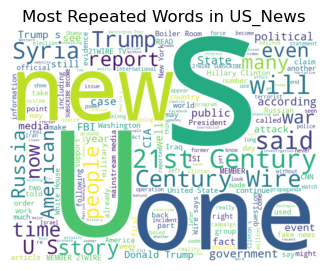

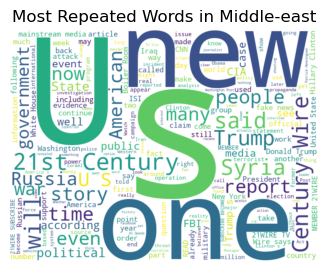

In [15]:
# Plot word clouds for each news subject
subjects = df["subject"].unique()
for subject in subjects:
    text = ' '.join(df.loc[df["subject"]==subject]["text"])
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Repeated Words in {subject}")
    plt.show()

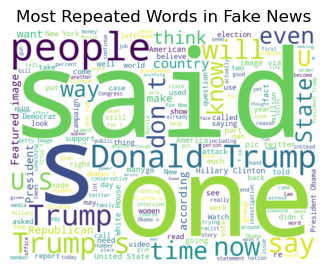

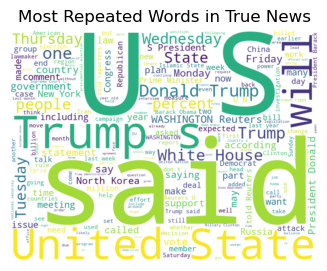

In [16]:
# Plot word clouds for each state of news reality
for status in [0, 1]:
    text = ' '.join(df.loc[df["status"]==status]["text"])
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if status == 0:
        plt.title(f"Most Repeated Words in Fake News")
    else:
        plt.title(f"Most Repeated Words in True News")
    plt.show()

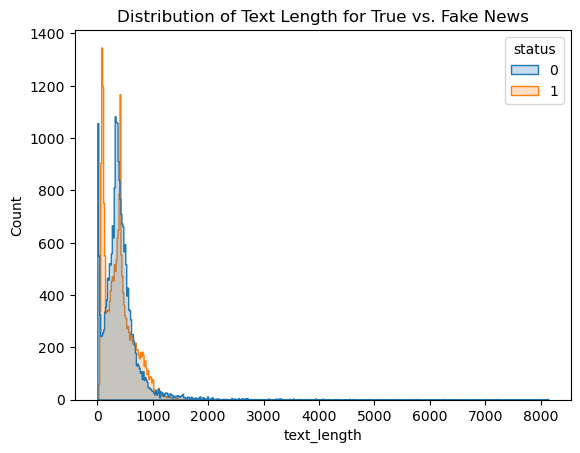

In [17]:
# Creating a distribution plot for the length of news content
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='text_length', hue='status', element='step', stat='count', common_norm=False)
plt.title('Distribution of Text Length for True vs. Fake News')
plt.show()
df.drop('text_length', axis=1, inplace=True)

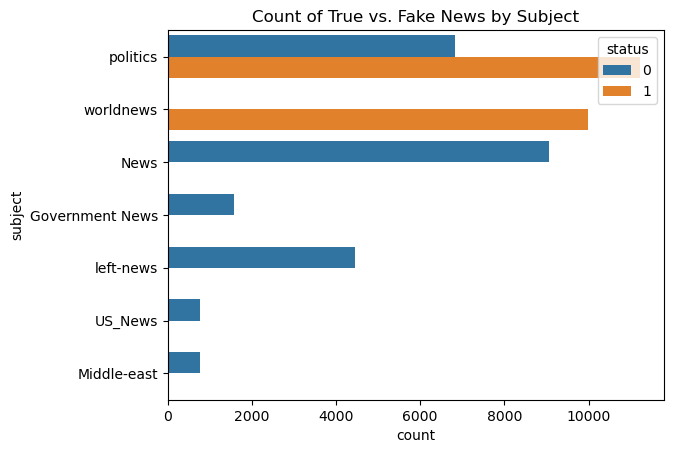

In [18]:
# Plotting the count of True vs. Fake News by Subject
sns.countplot(y='subject', hue='status', data=df)
plt.title('Count of True vs. Fake News by Subject')
plt.show()

## Merging textual columns and reordering DataFrame columns

In [31]:
df_temp = df.copy()
df_temp["content"] = df_temp["title"] + " " + df_temp["text"]
df_temp.drop(["date", "title", "text"], axis=1, inplace=True)
df_temp = df_temp.iloc[:, [2,0,1]]

In [32]:
df_temp.head()

,content,subject,status
0,"As U.S. budget fight looms, Republicans flip t...",politics,1
1,U.S. military to accept transgender recruits o...,politics,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politics,1
3,FBI Russia probe helped by Australian diplomat...,politics,1
4,Trump wants Postal Service to charge 'much mor...,politics,1


## Text preprocessing functions

In [33]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
p = inflect.engine()

In [34]:
def lower_case(text):
    return text.lower()

In [35]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [36]:
def convert_number(text):
    temp_str = text.split()
    new_string = []

    for word in temp_str:
        if word.isdigit():
            temp = p.number_to_words(word)
            new_string.append(temp)

        else:
            new_string.append(word)
            
    temp_str = ' '.join(new_string)
    return temp_str

In [37]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [38]:
def remove_whitespace(text):
    return " ".join(text.split())

In [39]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [40]:
def tokenization(text):
    return word_tokenize(text)

In [41]:
def stemming(text):
    singles = [stemmer.stem(word) for word in text]
    return singles

In [42]:
def lemmatizing(text):
    lemm_text = [lemmatizer.lemmatize(word) for word in text]
    return lemm_text

In [43]:
def clean_text(content):
    content = lower_case(content)
    content = convert_number(content)
    content = remove_punctuation(content)
    content = remove_whitespace(content)
    content = remove_stopwords(content)
    content = tokenization(content)
    content = lemmatizing(content)
    
    return ' '.join(content)

## Preprocessing the text data

In [44]:
df_temp["content"] = df_temp["content"].apply(lambda x: clean_text(x))

In [46]:
df_temp.head(10)

,content,subject,status
0,u budget fight loom republican flip fiscal scr...,politics,1
1,u military accept transgender recruit monday p...,politics,1
2,senior u republican senator let mr mueller job...,politics,1
3,fbi russia probe helped australian diplomat ti...,politics,1
4,trump want postal service charge much amazon s...,politics,1
5,white house congress prepare talk spending imm...,politics,1
6,trump say russia probe fair timeline unclear n...,politics,1
7,factbox trump twitter dec 29 approval rating a...,politics,1
8,trump twitter dec 28 global warming following ...,politics,1
9,alabama official certify senatorelect jones to...,politics,1


## Defining feature and label

In [47]:
x = df_temp["content"]
y = df_temp["status"]

## Train-test spliting

In [48]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Text Embedding - Convert text into a numerical format using different methods

### 1 - CountVectorizer method

In [49]:
count_vectorizer = CountVectorizer()
X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)

### 2 - TF-IDF method

In [50]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Model Training and Evaluation

### Model Training and Evaluation -> 1- Naive Bayes using Count Vectorizer-transformed data

In [58]:
# Train Naive Bayes classifier using Count Vectorizer-transformed data
nb_clf_cv = MultinomialNB()
nb_clf_cv.fit(X_train_cv, y_train)

MultinomialNB()

In [66]:
# Assess the performance of the Naive Bayes classifier on the training data
nb_cv_train_predictions = nb_clf_cv.predict(X_train_cv)
nb_cv_train_accuracy = accuracy_score(y_train, nb_cv_train_predictions)
"NB accuracy on the Count Vectorizer-transformed training data: ", round(nb_cv_train_accuracy, 3)

('NB accuracy on the Count Vectorizer-transformed training data: ', 0.97)

In [69]:
# Assess the performance of the Naive Bayes classifier on the testing data
nb_cv_predictions = nb_clf_cv.predict(X_test_cv)
nb_cv_accuracy = accuracy_score(y_test, nb_cv_predictions)
"NB accuracy on the Count Vectorizer-transformed testing data", round(nb_cv_accuracy, 3)

('NB accuracy on the Count Vectorizer-transformed testing data', 0.963)

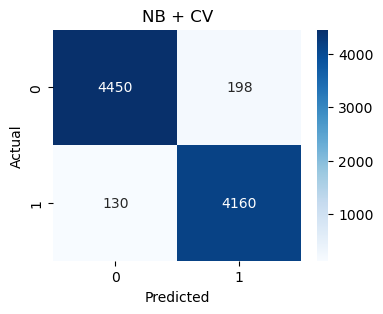

In [70]:
# Generate confusion matrix for predictions on testing data
cm_nbc = confusion_matrix(y_test, nb_cv_predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_nbc, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('NB + CV')
plt.show()

### Model Training and Evaluation -> 2- Naive Bayes using TF-IDF Vectorizer-transformed data

In [60]:
# Train Naive Bayes classifier using TF-IDF Vectorizer-transformed data
nb_clf_tfidf = MultinomialNB()
nb_clf_tfidf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [71]:
# Assess the performance of the Naive Bayes classifier on the training data
nb_tfidf_train_predictions = nb_clf_tfidf.predict(X_train_tfidf)
nb_tfidf_train_accuracy = accuracy_score(y_train, nb_tfidf_train_predictions)
"NB accuracy on the TF-IDF Vectorizer-transformed training data: ", round(nb_tfidf_train_accuracy, 3)

('NB accuracy on the TF-IDF Vectorizer-transformed training data: ', 0.954)

In [72]:
# Assess the performance of the Naive Bayes classifier on the testing data
nb_tfidf_predictions = nb_clf_tfidf.predict(X_test_tfidf)
nb_tfidf_accuracy = accuracy_score(y_test, nb_tfidf_predictions)
"NB accuracy on the TF-IDF Vectorizer-transformed testing data: ", round(nb_tfidf_accuracy, 3)

('NB accuracy on the TF-IDF Vectorizer-transformed testing data: ', 0.948)

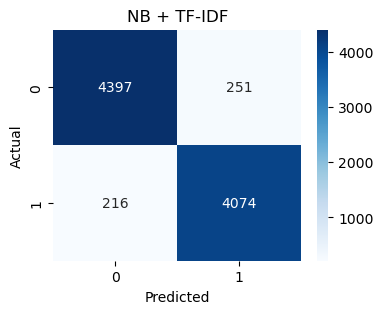

In [73]:
# Generate confusion matrix for predictions on testing data
cm_nbt = confusion_matrix(y_test, nb_tfidf_predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_nbt, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('NB + TF-IDF')
plt.show()

### Model Training and Evaluation -> 3- SVM using Count Vectorizer-transformed data

In [74]:
# Train SVM classifier using Count Vectorizer-transformed data
svm_clf_cv = SVC(kernel='linear')
svm_clf_cv.fit(X_train_cv, y_train)

SVC(kernel='linear')

In [75]:
# Assess the performance of the SVM classifier on the training data
svm_cv_train_predictions = svm_clf_cv.predict(X_train_cv)
svm_cv_train_accuracy = accuracy_score(y_train, svm_cv_train_predictions)
"SVM accuracy on the Count Vectorizer-transformed training data: ", round(svm_cv_train_accuracy, 3)

('SVM accuracy on the Count Vectorizer-transformed training data: ', 1.0)

In [77]:
# Assess the performance of the SVM classifier on the testing data
svm_cv_predictions = svm_clf_cv.predict(X_test_cv)
svm_cv_accuracy = accuracy_score(y_test, svm_cv_predictions)
"SVM accuracy on the Count Vectorizer-transformed testing data", round(svm_cv_accuracy, 3)

('SVM accuracy on the Count Vectorizer-transformed testing data', 0.996)

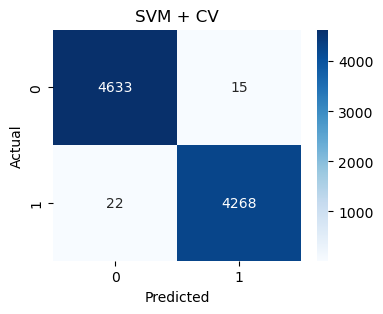

In [78]:
# Generate confusion matrix for predictions on testing data
cm_svmc = confusion_matrix(y_test, svm_cv_predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_svmc, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM + CV')
plt.show()

### Model Training and Evaluation -> 4- SVM using TF-IDF Vectorizer-transformed data

In [79]:
# Train SVM classifier using TF-IDF Vectorizer-transformed data
svm_clf_tfidf = SVC(kernel='linear')
svm_clf_tfidf.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [80]:
# Assess the performance of the SVM classifier on the training data
svm_tfidf_train_predictions = svm_clf_tfidf.predict(X_train_tfidf)
svm_tfidf_train_accuracy = accuracy_score(y_train, svm_tfidf_train_predictions)
"SVM accuracy on the TF-IDF Vectorizer-transformed training data: ", round(svm_tfidf_train_accuracy, 3)

('SVM accuracy on the TF-IDF Vectorizer-transformed training data: ', 0.999)

In [81]:
# Assess the performance of the SVM classifier on the testing data
svm_tfidf_predictions = svm_clf_tfidf.predict(X_test_tfidf)
svm_tfidf_accuracy = accuracy_score(y_test, svm_tfidf_predictions)
"SVM accuracy on the TF-IDF Vectorizer-transformed testing data: ", round(svm_tfidf_accuracy, 3)

('SVM accuracy on the TF-IDF Vectorizer-transformed testing data: ', 0.994)

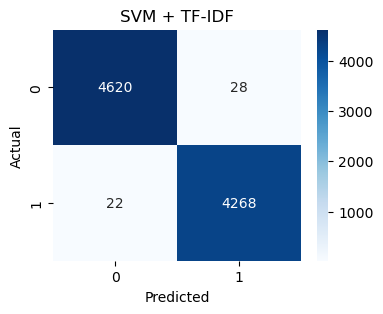

In [85]:
# Generate confusion matrix for predictions on testing data
cm_svmt = confusion_matrix(y_test, svm_tfidf_predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_svmt, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM + TF-IDF')
plt.show()

## SVM, which was trained on Count vectorized data, outperformed other models with the highest accuracy.